# Decision Tree - **training**, **validating**, **visualizing** and hyperparameter **tunning**

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import tree, preprocessing
import graphviz 
from sklearn.ensemble import RandomForestClassifier

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Remove unwanted columns

In [6]:
train = train.drop(["Name","Ticket","Cabin"],1)
test = test.drop(["Name","Ticket","Cabin"],1)

## Take care of missing values

In [7]:
complete_set = pd.concat([train.drop(["Survived"],1)])
complete_set.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
complete_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


### Method 1 - Remove lines with null age

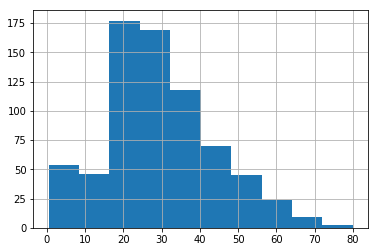

In [ ]:
plt.figure()
complete_set.Age.dropna().hist()

### Method 2 - Replace null ages by a random value with the same distribution as the data

C:\Users\ASSG\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


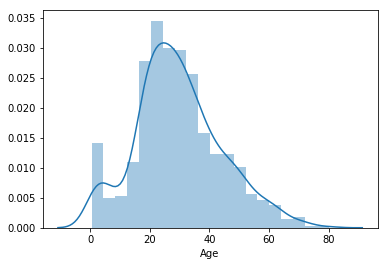

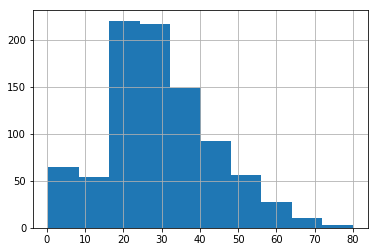

In [ ]:
x,y = sns.distplot(complete_set.Age.dropna()).get_lines()[0].get_data()
y=y[x>0]
x=x[x>0]

fillvalues = pd.Series(data = np.random.choice(x,complete_set.Age.isnull().sum(),p=y/y.sum()), 
          index = complete_set[complete_set.Age.isnull()].index)

plt.figure()
complete_set.Age.fillna(fillvalues).hist()

To try later: create a flag IsNull to put every row without a value for Age

### Try a decision tree model

#### First clean the data: remove NaNs, Label-Encode Sex, OneHotEncode Embarked  

In [ ]:
complete_set[complete_set.Age.isnull()].head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,6,3,male,NaN,0,0,8.4583,Q
17,18,2,male,NaN,0,0,13.0000,S
19,20,3,female,NaN,0,0,7.2250,C
26,27,3,male,NaN,0,0,7.2250,C
28,29,3,female,NaN,0,0,7.8792,Q


In [ ]:
train_clean = train.copy()
test_clean = test.copy()
le_Sex = preprocessing.LabelEncoder()
train_clean["Sex"] = le_Sex.fit_transform(train.Sex)
test_clean["Sex"] = le_Sex.transform(test.Sex)

le_Embarked = preprocessing.LabelEncoder()
OHE_Embarked = preprocessing.OneHotEncoder()

embarked_num = le_Embarked.fit_transform(train.Embarked.fillna("Null")).reshape(-1,1)
embarked_num_test = le_Embarked.transform(test.Embarked.fillna("Null")).reshape(-1,1)

embarked_ohe_train = pd.DataFrame(OHE_Embarked.fit_transform(embarked_num).toarray(), dtype=int, columns = "Embarked_in_" + le_Embarked.classes_)
embarked_ohe_test = pd.DataFrame(OHE_Embarked.transform(embarked_num_test).toarray(), dtype=int, columns = "Embarked_in_" + le_Embarked.classes_)

train_clean = pd.concat([train_clean.drop(["Embarked","PassengerId"],1), embarked_ohe_train],1).dropna()
test_clean = pd.concat([test_clean.drop(["Embarked","PassengerId"],1), embarked_ohe_test],1)
test_clean["Age"] = test_clean.Age.fillna(train_clean.Age.mean())
test_clean["Fare"] = test_clean.Fare.fillna(train_clean.Fare.median())
train_clean.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_in_C,Embarked_in_Null,Embarked_in_Q,Embarked_in_S
0,0,3,1,22.0,1,0,7.2500,0,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,0,1
6,0,1,1,54.0,0,0,51.8625,0,0,0,1
7,0,3,1,2.0,3,1,21.0750,0,0,0,1
8,1,3,0,27.0,0,2,11.1333,0,0,0,1
9,1,2,0,14.0,1,0,30.0708,1,0,0,0
10,1,3,0,4.0,1,1,16.7000,0,0,0,1


In [ ]:
test_clean.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_in_C,Embarked_in_Null,Embarked_in_Q,Embarked_in_S
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000
mean,2.265550,0.636364,30.154603,0.447368,0.392344,35.624957,0.244019,0.0,0.110048,0.645933
std,0.841838,0.481622,12.636666,0.896760,0.981429,55.840519,0.430019,0.0,0.313324,0.478803
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,0.000000,0.0,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.0,0.000000,1.000000
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.500000,0.000000,0.0,0.000000,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,1.000000,0.0,1.000000,1.000000


### Experiment Decision trees
to remember [https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)]:
* Accuracy: % of Guesses that were right = (TP + TN)/All
* Recall: % of Real Positives Guessed correctly = TP/(TP + FN)
* Precision: % of Guessed Positives which are correct = TP/(TP + FP)

In [14]:
def eval_model(y, pred):
    r2 = r2_score(y, pred)
    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)
    cm = confusion_matrix(y, pred)
    cm_df = pd.DataFrame(cm/cm.sum(), columns = ("Pred=0", "Pred=1"), index = ("y=0", "y=1")).round(2)
    print("R2:\t\t{0:.3}\nAccuracy:\t{1:.3}\nPrecision:\t{2:.3}\nRecall:\t\t{3:.3}\nF1:\t\t{4:.3}".format(r2,acc,prec,rec,f1))
    print("Confusion matrix:\n" , cm_df,"\n\n")
    return prec, rec

In [ ]:
X=train_clean.drop(["Survived"],1).values
y=train_clean.Survived.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
model1 = tree.DecisionTreeClassifier(min_samples_leaf=1e-6)
model1.fit(X_train,y_train)
print("Train set")
eval_model(y_train, model1.predict(X_train))
print("Test set")
eval_model(y_test, model1.predict(X_test))

R2:		0.941
Accuracy:	0.986
Precision:	1.0
Recall:		0.964
F1:		0.982
Confusion matrix:
      Pred=0  Pred=1
y=0    0.61    0.00
y=1    0.01    0.38 


R2:		0.108
Accuracy:	0.778
Precision:	0.867
Recall:		0.684
F1:		0.765
Confusion matrix:
      Pred=0  Pred=1
y=0    0.42    0.06
y=1    0.17    0.36 




(0.8666666666666667, 0.6842105263157895)

### With cross validation

In [ ]:
def get_acc(model, X, y, scorer):
    v = cross_val_score(model, X, y, scoring = scorer)
    #print("{0:.3} +- {1:.3}".format(v.mean(), v.std()))
    return (v.mean(), v.std())
get_acc(model1, X, y, 'accuracy')

(0.7717236427611315, 0.004469190203640118)

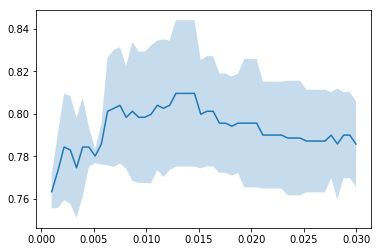

In [ ]:
def find_best_par_value(get_model, list_par_values):
    mean_acc = []

    for par_value in list_par_values:
        temp_model = get_model(par_value)
        mean_acc.append(get_acc(temp_model, X, y, 'accuracy'))
    plt.figure()
    mean_acc = np.array(mean_acc)
    
    plt.plot(list_par_values, mean_acc[:,0])
    plt.fill_between(list_par_values, mean_acc[:,0] - mean_acc[:,1], mean_acc[:,0] + mean_acc[:,1], alpha=0.25)
    return np.array(mean_acc)
    
acc=find_best_par_value(lambda x: tree.DecisionTreeClassifier(min_samples_leaf=x), np.linspace(0.001,0.03))

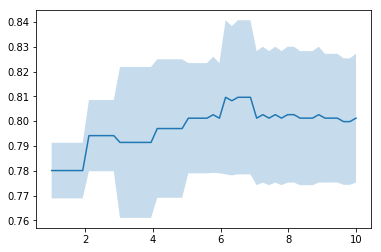

In [ ]:
acc=find_best_par_value(lambda x: tree.DecisionTreeClassifier(min_samples_leaf=0.015, max_depth = x), np.linspace(1,10))

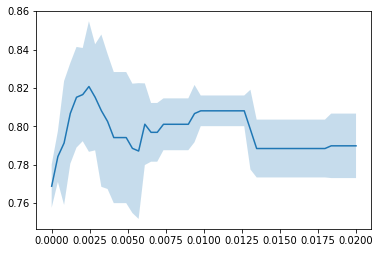

In [ ]:
acc=find_best_par_value(
    lambda x: tree.DecisionTreeClassifier(
        min_impurity_decrease = x
        ), 
    np.linspace(0,.02))

Hence mean_lif_size should be around 0.015

## At last: Generate and export prediction given by the best model

In [ ]:
final_model = tree.DecisionTreeClassifier(min_impurity_decrease = 0.0025).fit(X,y)
pred_df = test.copy()

pred_df["Survived"] = final_model.predict(test_clean)
pred_df = pred_df[["PassengerId", "Survived"]]
pred_df.head()
pred_df.to_csv("pred_dec_tree1.csv",index=False)

### Print decision tree

In [ ]:
dot_data = tree.export_graphviz(final_model, out_file=None, 
                         feature_names=train_clean.drop(["Survived"],1).columns,
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render('./dec_tree_min_leaf_size_5', view=True)

'./dec_tree_min_leaf_size_5.pdf'

## Although we keep getting accuracies up to 0.86 when making a submission in kaggle the score is much lower!
A possible explanation: here we're calculating accuracy after dropping the NaN Ages while to do the submission we're replacing them by the mean.
This indicates that the age is a very important feature for predicting survival.
## Hence we need a better way to treat missing age values in the test set
### Two possible solutions: 
1. Treat missing ages as a separate value (-10 for example)
2. Create a model to predict age

## 1.

In [78]:
train_clean2 = train.copy()
test_clean2 = test.copy()
le_Sex = preprocessing.LabelEncoder()
train_clean2["Sex"] = le_Sex.fit_transform(train.Sex)
test_clean2["Sex"] = le_Sex.transform(test.Sex)

le_Embarked = preprocessing.LabelEncoder()
OHE_Embarked = preprocessing.OneHotEncoder()

embarked_num = le_Embarked.fit_transform(train.Embarked.fillna("Null")).reshape(-1,1)
embarked_num_test = le_Embarked.transform(test.Embarked.fillna("Null")).reshape(-1,1)

embarked_ohe_train = pd.DataFrame(OHE_Embarked.fit_transform(embarked_num).toarray(), dtype=int, columns = "Embarked_in_" + le_Embarked.classes_)
embarked_ohe_test = pd.DataFrame(OHE_Embarked.transform(embarked_num_test).toarray(), dtype=int, columns = "Embarked_in_" + le_Embarked.classes_)

train_clean2 = pd.concat([train_clean2.drop(["Embarked","PassengerId"],1), embarked_ohe_train],1)
train_clean2["Age"].fillna(-10, inplace = True)

test_clean2 = pd.concat([test_clean2.drop(["Embarked","PassengerId"],1), embarked_ohe_test],1)
test_clean2.Age.fillna(-10, inplace = True)
test_clean2["Fare"].fillna(train_clean2.Fare.median(), inplace = True)
train_clean2.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_in_C,Embarked_in_Null,Embarked_in_Q,Embarked_in_S
0,0,3,1,22.0,1,0,7.2500,0,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,0,1
5,0,3,1,-10.0,0,0,8.4583,0,0,1,0
6,0,1,1,54.0,0,0,51.8625,0,0,0,1
7,0,3,1,2.0,3,1,21.0750,0,0,0,1
8,1,3,0,27.0,0,2,11.1333,0,0,0,1
9,1,2,0,14.0,1,0,30.0708,1,0,0,0


In [79]:
X=train_clean2.drop(["Survived"],1).values
y=train_clean2.Survived.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [80]:
model1 = tree.DecisionTreeClassifier(min_samples_leaf=0.0105)
model1.fit(X_train,y_train)
print("Train set")
eval_model(y_train, model1.predict(X_train))
print("Test set")
eval_model(y_test, model1.predict(X_test))

Train set
R2:		0.423
Accuracy:	0.863
Precision:	0.859
Recall:		0.776
F1:		0.815
Confusion matrix:
      Pred=0  Pred=1
y=0    0.56    0.05
y=1    0.09    0.30 


Test set
R2:		0.186
Accuracy:	0.822
Precision:	0.697
Recall:		0.793
F1:		0.742
Confusion matrix:
      Pred=0  Pred=1
y=0    0.57    0.11
y=1    0.07    0.26 




(0.696969696969697, 0.7931034482758621)

In [81]:
final_model2 = tree.DecisionTreeClassifier(min_samples_leaf = 0.0105).fit(X,y)
pred_df = test.copy()

pred_df["Survived"] = final_model2.predict(test_clean2)
pred_df = pred_df[["PassengerId", "Survived"]]
pred_df.head()
pred_df.to_csv("pred_dec_tree_sepNan.csv",index=False)

This submission resulted in the following score: 0.75119

### Bonus: Random Forest

In [96]:
model = RandomForestClassifier(n_estimators=10)

model.fit(X_train,y_train)
print("Train set")
eval_model(y_train, model.predict(X_train))
print("Test set")
eval_model(y_test, model.predict(X_test))

Train set
R2:		0.837
Accuracy:	0.961
Precision:	0.98
Recall:		0.92
F1:		0.949
Confusion matrix:
      Pred=0  Pred=1
y=0    0.60    0.01
y=1    0.03    0.36 


Test set
R2:		0.186
Accuracy:	0.822
Precision:	0.686
Recall:		0.828
F1:		0.75
Confusion matrix:
      Pred=0  Pred=1
y=0    0.56    0.12
y=1    0.06    0.27 




(0.6857142857142857, 0.8275862068965517)

In [86]:
final_model3 = RandomForestClassifier().fit(X,y)
pred_df = test.copy()

pred_df["Survived"] = final_model3.predict(test_clean2)
pred_df = pred_df[["PassengerId", "Survived"]]
pred_df.to_csv("pred_random_tree_sepNan.csv",index=False)

This submission resulted in the following score: 0.78468